### Diabetic Retinopathy Classification

#### 1. Import Libraries

In [1]:
# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#### 2. Data Preprocessing

In [2]:
# Set image dimensions (ShuffleNet works well with 224x224)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Dataset paths
train_dir = r"C:\Users\srira\Downloads\907\Diabetic Retinopathy Dataset\train"
valid_dir = r"C:\Users\srira\Downloads\907\Diabetic Retinopathy Dataset\valid"
test_dir  = r"C:\Users\srira\Downloads\907\Diabetic Retinopathy Dataset\test"

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test should only be rescaled
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Optional: check class indices
print("Class Indices:", train_generator.class_indices)

Found 5828 images belonging to 5 classes.
Found 834 images belonging to 5 classes.
Found 416 images belonging to 5 classes.
Class Indices: {'DR No': 0, 'DR Proliferative': 1, 'Mild': 2, 'Moderate': 3, 'Severe': 4}



Image count per class in Training Set:
Class DR No: 2674 images
Class DR Proliferative: 446 images
Class Mild: 564 images
Class Moderate: 1446 images
Class Severe: 698 images


C:\Users\srira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


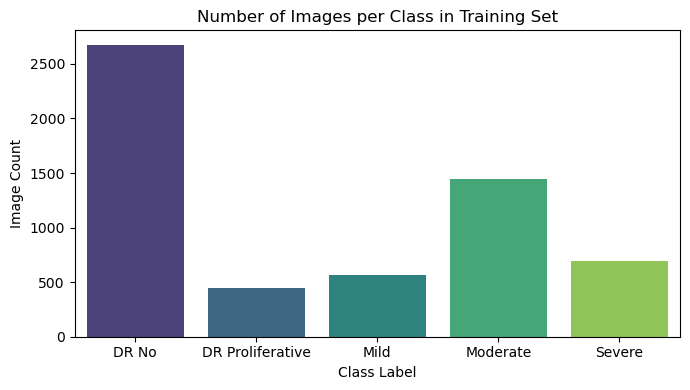


Image count per class in Validation Set:
Class DR No: 403 images
Class DR Proliferative: 62 images
Class Mild: 91 images
Class Moderate: 198 images
Class Severe: 80 images


C:\Users\srira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


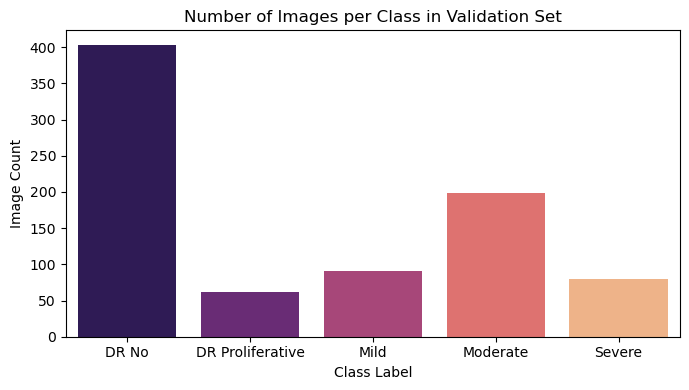


Image count per class in Test Set:
Class DR No: 207 images
Class DR Proliferative: 26 images
Class Mild: 40 images
Class Moderate: 104 images
Class Severe: 39 images


C:\Users\srira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


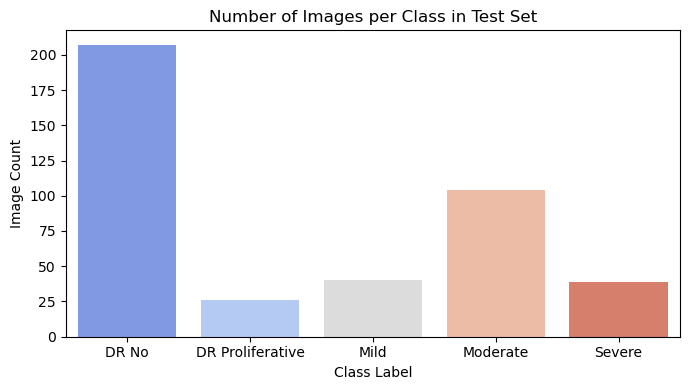

In [4]:
# Function to count images and plot distribution
def count_images_per_class(directory, title, color_palette):
    class_counts = {}
    class_names = os.listdir(directory)

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    print(f"\nImage count per class in {title}:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} images")

    # Bar plot
    plt.figure(figsize=(7, 4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=color_palette)
    plt.title(f"Number of Images per Class in {title}")
    plt.xlabel("Class Label")
    plt.ylabel("Image Count")
    plt.tight_layout()
    plt.show()

# Call the function for all three sets
count_images_per_class(train_dir, "Training Set", "viridis")
count_images_per_class(valid_dir, "Validation Set", "magma")
count_images_per_class(test_dir, "Test Set", "coolwarm")

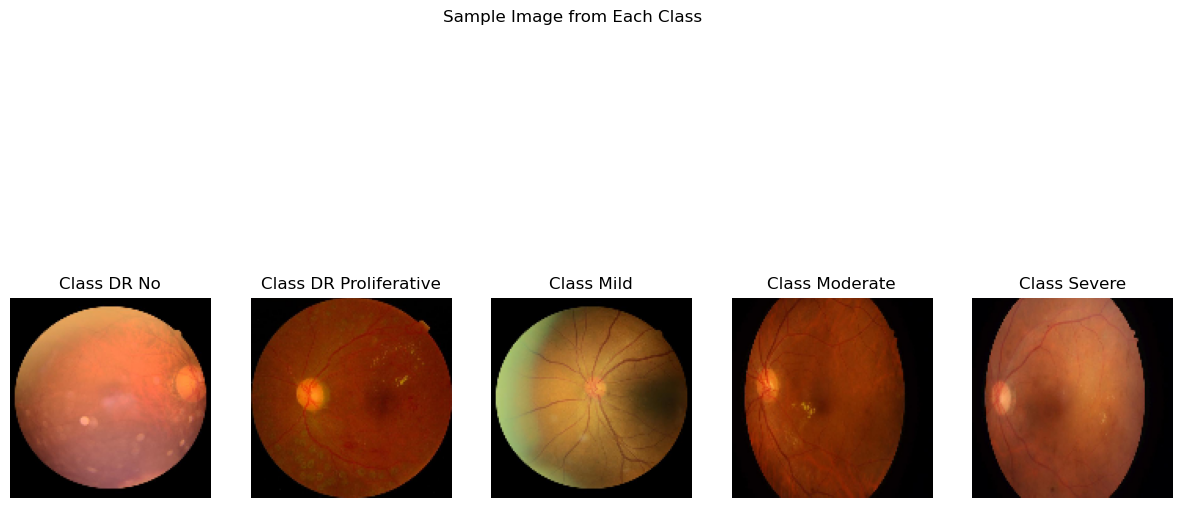

In [6]:
def show_samples_per_class(base_dir, class_names, img_size=(128, 128)):
    plt.figure(figsize=(15, 8))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(base_dir, class_name)
        img_list = os.listdir(class_path)
        img_path = os.path.join(class_path, img_list[0])
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(f"Class {class_name}")
        plt.axis('off')
    plt.suptitle("Sample Image from Each Class")
    plt.show()

show_samples_per_class(train_dir, classes)

#### 3. Model Building

In [7]:
# Image size and number of classes
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 5  # for DR stages 0-4

# Load lightweight pre-trained base model (acts like ShuffleNet)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model for transfer learning
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
# Build custom head on top of base
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# Combine into full model
model = Model(inputs, outputs)

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### 4. Model Training

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Callbacks: Early stopping and model checkpoint
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=10,               
    validation_data=valid_generator,
    validation_steps=20,               
    epochs=20,                 
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4431 - loss: 1.4495
Epoch 1: val_accuracy did not improve from 0.57344
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.4440 - loss: 1.4487 - val_accuracy: 0.5688 - val_loss: 1.2112
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5025 - loss: 1.3762
Epoch 2: val_accuracy did not improve from 0.57344
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5001 - loss: 1.3791 - val_accuracy: 0.5484 - val_loss: 1.2393
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4673 - loss: 1.3740
Epoch 3: val_accuracy did not improve from 0.57344
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4671 - loss: 1.3762 - val_accuracy: 0.5422 - val_loss: 1.2042
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4917 - loss: 1.4081  
Epoch 4: val_accuracy did not improve from 0.57344
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.4908 - loss: 1.4086 - val_accuracy: 0.5453 - val_loss: 1.2035
Ep

10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5797 - loss: 1.1715 - val_accuracy: 0.5781 - val_loss: 1.1620
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5039 - loss: 1.3314
Epoch 8: val_accuracy did not improve from 0.57812
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5036 - loss: 1.3341 - val_accuracy: 0.5688 - val_loss: 1.1741
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4587 - loss: 1.3867
Epoch 9: val_accuracy did not improve from 0.57812
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.4596 - loss: 1.3861 - val_accuracy: 0.5516 - val_loss: 1.1725
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5005 - loss: 1.2873  
Epoch 10: val_accuracy did not improve from 0.57812
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.4982 - loss: 1.2906 - val_accuracy: 0.5547 - val_loss: 1.1742
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


#### 5. Model Evaluation

In [16]:
# Load the best saved model
from tensorflow.keras.models import load_model
# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

416/416 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.8173 - loss: 0.7506

Test Accuracy: 57.69%


416/416 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step

Classification Report:
                  precision    recall  f1-score   support

           DR No       0.50      0.85      0.63       207
DR Proliferative       0.03      0.08      0.04        26
            Mild       0.00      0.00      0.00        40
        Moderate       0.00      0.00      0.00       104
          Severe       0.00      0.00      0.00        39

        accuracy                           0.43       416
       macro avg       0.11      0.18      0.13       416
    weighted avg       0.25      0.43      0.32       416



C:\Users\srira\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srira\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srira\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 600x500 with 0 Axes>

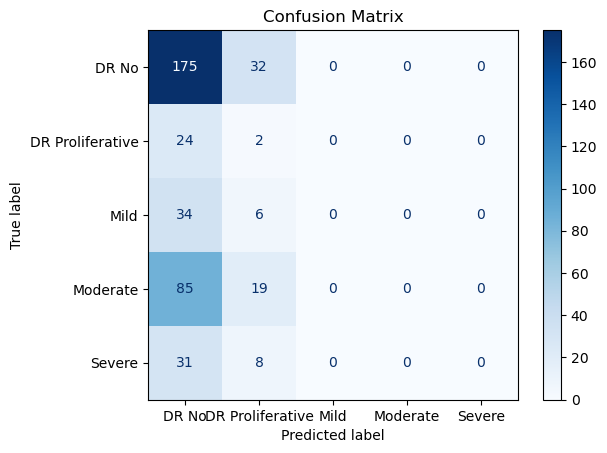

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Get number of test samples and batch size
num_test_samples = test_generator.samples
batch_size = test_generator.batch_size

# Ensure steps is an integer
steps = int(np.ceil(num_test_samples / batch_size))

# Predict on test set
y_pred_probs = model.predict(test_generator, steps=steps)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Ensure y_pred matches y_true in length
y_pred = y_pred[:len(y_true)]

# Classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()